In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average

In [7]:
f = h5py.File('shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

OSError: Unable to synchronously open file (bad object header version number)

In [2]:
f = h5py.File('shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5', 'r')

In [3]:
x = f.get('x')
y = f.get('y')
t = f.get('t')

In [4]:
x = np.array(x)
y = np.array(y)
t = np.array(t)

In [5]:
surf3d = surface_core.surface_from_file("shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5")

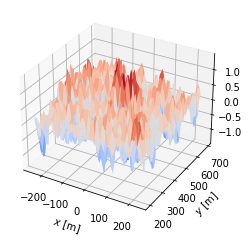

In [6]:
surf3d.plot_3d_surface()
plt.show()

In [7]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

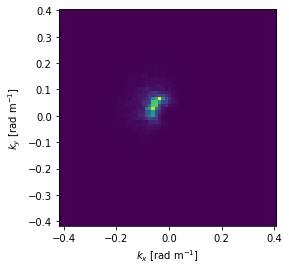

In [8]:
spec3d.plot()

2 2.0001473227855016 191


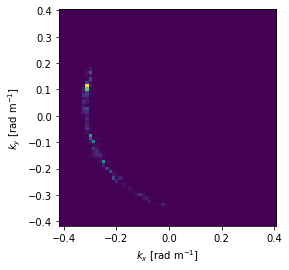

In [9]:
spec3d.plot_w_slice(2)
# Method for 3D, plot kx-ky spectra at a given w

In [10]:
def cart2pol(x, y, cart, Nr=200, Ntheta=360, r_out=None, theta_out=None):
    '''
    Conversion from cartesian to polar coordinates
    Extrapolation possible (can be avoided by setting r_out, theta_out accordingly)
    Parameter:
    ----------
    input:
            x       array
                    1d array of x-axis
            y       array
                    1d array of y-axis
            cart    2d array (dimensions matching x,y, 'ij'-indexing)
                    matrix to be converted
    output:
            r       array
                    1d array of r-axis
            theta   array
                    1d array of theta-axis
            pol     2d array
                    data in polar coordinats
    '''
    xx, yy = np.meshgrid(x, y, indexing='ij')
    theta_cart = np.arctan2(yy, xx)
    r_cart = np.sqrt(xx**2 + yy**2)
    rmin = np.min(r_cart)
    rmax = np.max(r_cart)
    tmin = np.min(theta_cart)
    tmax = np.max(theta_cart)
    if theta_out is None:
        theta = np.linspace(tmin, tmax, Ntheta, endpoint=True)
    else:
        theta = theta_out
        Ntheta = len(theta)
    if r_out is None:
        r = np.linspace(rmin, rmax, Nr, endpoint=True)
    else:
        r = r_out
        Nr = len(r)
    F = RectBivariateSpline(x, y, cart)
    rr, th = np.meshgrid(r, theta, indexing='ij')
    x_pol = rr*np.cos(th)
    y_pol = rr*np.sin(th)
    pol = F(x_pol.ravel(), y_pol.ravel(), grid=False).reshape((Nr, Ntheta))
    return r, theta, pol

In [11]:
def cart2cylindrical(x, y, cart, Nr=200, Ntheta=360):
    '''
    blabla
    polar coordinates in (x,y)
    '''
    r = np.zeros(Nr)
    theta = np.zeros(Ntheta)
    Nt = 600
    cylindrical = np.zeros((Nt, Nr, Ntheta))
    for i in range(0, Nt):
        r, theta, cylindrical[i,:,:] = cart2pol(x, y, cart[i,:,:], Nr, Ntheta)
    return r, theta, cylindrical

In [12]:
def transform_spectrum_to_polar(self, Nr, Ntheta):        
    return polar_coordinates.cart2cylindrical(t, self.kx, self.ky, self.spectrum, Nr=Nr, Ntheta=Ntheta)

In [13]:
spec3d.transform_spectrum_to_polar()

TypeError: cart2cylindrical() missing 1 required positional argument: 'cart'

## Transforming Data to Polars

In [40]:
kx_list = []
ky_list = []
# empty kx and ky lists for triplet values

thresh_freq = 1
max_freq = 2
step_size = 0.1
# Input frequencies values 

freqs = np.arange(thresh_freq, max_freq, step_size)

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[600//2:]-f))
    spec = spec3d.spectrum()
    spec_values = spec[600//2 + i,:,:]
    # Gives the spectrum values represented by colour
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_kx = spec3d.kx[max_index[0]]
    max_ky = spec3d.ky[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
    
    kx_list.append(max_kx)
    ky_list.append(max_ky)

In [81]:
kx = np.array(kx_list)
kx

array([-0.08885313, -0.11423973, -0.10154643, -0.12693304, -0.16501295,
       -0.19039955, -0.20309286, -0.24117277, -0.26655938, -0.26655938])

In [76]:
ky = np.array(ky_list)
ky

array([ 0.02538661,  0.0126933 ,  0.10154643,  0.10154643, -0.03807991,
        0.02538661,  0.11423973,  0.05077321,  0.05077321, -0.10154643])

In [77]:
r = np.sqrt( (kx)**2 + (ky)**2 )
r

array([0.09240865, 0.11494275, 0.14360834, 0.1625536 , 0.16934979,
       0.19208454, 0.23301808, 0.24645938, 0.27135184, 0.28524652])

In [78]:
theta = np.arctan(ky/kx)
theta

array([-0.27829966, -0.11065722, -0.78539816, -0.67474094,  0.22679885,
       -0.13255153, -0.51238946, -0.20749623, -0.18822151,  0.36397896])

In [79]:
_new_kx = r*np.cos(theta)
_new_kx

array([0.08885313, 0.11423973, 0.10154643, 0.12693304, 0.16501295,
       0.19039955, 0.20309286, 0.24117277, 0.26655938, 0.26655938])

In [80]:
_new_ky = r*np.sin(theta)
_new_ky

array([-0.02538661, -0.0126933 , -0.10154643, -0.10154643,  0.03807991,
       -0.02538661, -0.11423973, -0.05077321, -0.05077321,  0.10154643])

In [34]:
r, theta, spec_pol = polar_coordinates.cart2cylindrical(t, spec3d.kx, spec3d.ky, spec3d.spectrum(), Ntheta=200)
# Transforms data into polar co-ordiantes

In [25]:
r

array([0.        , 0.00297681, 0.00595361, 0.00893042, 0.01190722,
       0.01488403, 0.01786084, 0.02083764, 0.02381445, 0.02679125,
       0.02976806, 0.03274487, 0.03572167, 0.03869848, 0.04167528,
       0.04465209, 0.0476289 , 0.0506057 , 0.05358251, 0.05655931,
       0.05953612, 0.06251293, 0.06548973, 0.06846654, 0.07144334,
       0.07442015, 0.07739696, 0.08037376, 0.08335057, 0.08632737,
       0.08930418, 0.09228099, 0.09525779, 0.0982346 , 0.1012114 ,
       0.10418821, 0.10716502, 0.11014182, 0.11311863, 0.11609543,
       0.11907224, 0.12204905, 0.12502585, 0.12800266, 0.13097946,
       0.13395627, 0.13693308, 0.13990988, 0.14288669, 0.14586349,
       0.1488403 , 0.15181711, 0.15479391, 0.15777072, 0.16074752,
       0.16372433, 0.16670114, 0.16967794, 0.17265475, 0.17563155,
       0.17860836, 0.18158517, 0.18456197, 0.18753878, 0.19051558,
       0.19349239, 0.1964692 , 0.199446  , 0.20242281, 0.20539961,
       0.20837642, 0.21135323, 0.21433003, 0.21730684, 0.22028

In [26]:
theta

array([-3.11129889e+00, -3.07987733e+00, -3.04845576e+00, -3.01703420e+00,
       -2.98561263e+00, -2.95419107e+00, -2.92276950e+00, -2.89134793e+00,
       -2.85992637e+00, -2.82850480e+00, -2.79708324e+00, -2.76566167e+00,
       -2.73424011e+00, -2.70281854e+00, -2.67139698e+00, -2.63997541e+00,
       -2.60855384e+00, -2.57713228e+00, -2.54571071e+00, -2.51428915e+00,
       -2.48286758e+00, -2.45144602e+00, -2.42002445e+00, -2.38860289e+00,
       -2.35718132e+00, -2.32575975e+00, -2.29433819e+00, -2.26291662e+00,
       -2.23149506e+00, -2.20007349e+00, -2.16865193e+00, -2.13723036e+00,
       -2.10580880e+00, -2.07438723e+00, -2.04296566e+00, -2.01154410e+00,
       -1.98012253e+00, -1.94870097e+00, -1.91727940e+00, -1.88585784e+00,
       -1.85443627e+00, -1.82301471e+00, -1.79159314e+00, -1.76017157e+00,
       -1.72875001e+00, -1.69732844e+00, -1.66590688e+00, -1.63448531e+00,
       -1.60306375e+00, -1.57164218e+00, -1.54022062e+00, -1.50879905e+00,
       -1.47737748e+00, -

In [27]:
r.shape

(200,)

In [28]:
theta.shape

(200,)

In [32]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [37]:
kx_list = []
ky_list = []
# empty kx and ky lists for triplet values

thresh_freq = 1
max_freq = 2
step_size = 0.1
# Input frequencies values 

freqs = np.arange(thresh_freq, max_freq, step_size)

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[600//2:]-f))
    spec = spec_pol
    spec_values = spec[600//2 + i,:,:]
    # Gives the spectrum values represented by colour
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_r = r[max_index[0]]
    max_theta = theta[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
    
    kx_list.append(max_r)
    ky_list.append(max_theta)

In [39]:
max_theta

-2.765661672465647

In [29]:
spec_pol.shape

(600, 200, 200)

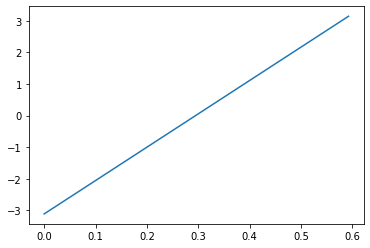

In [31]:
plt.plot(r,theta)